<a href="https://colab.research.google.com/github/malikkotb/Seminar_SS23/blob/main/Notebook_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with a Convolutional Neural Network

This step-by-step guide through building a Convolutional Neural Network for Image Classification assumes you have already successfully managed to install PyTorch on your computer and were able to create a new Jupyter Notebook to start coding.

The majority of the code in my implementation is derived from the following sources:

*   https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
* https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-data
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212
* https://pytorch.org/vision/stable/index.html

I have made necessary modifications and adjustments to the code from these sources to better suit my needs, preferences, and understanding of the problem at hand.

## Imports

These are imports that we will be needing and using throughout the process of building our entire network.

In [ ]:
# The below imports can be found on https://pytorch.org/docs/
import torch # loading the PyTorch library
import torch.nn as nn # for defining a neural network
import torch.nn.functional as F # for importing activation functions like ReLu
from torch.utils.data import DataLoader # for
from torchvision import datasets, transforms, models # for performing transformations on the images
from torchvision.utils import make_grid # to view a batch of images
import os # https://docs.python.org/3/library/os.html

import numpy as np # numpy library
import pandas as pd # pandas library
import matplotlib.pyplot as plt # matplotlib library for visualization
%matplotlib inline

# from: https://github.com/tqdm/tqdm (A progressbar for python)
from tqdm import tqdm

# So we can ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# setup GPU
# source: https://pytorch.org/docs/stable/cuda.html
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU



## Preprocessing starts here

## Load the dataset

In this section we will load in the dataset. In this project I have chosen the "Animal Faces" dataset from https://www.kaggle.com/datasets/andrewmvd/animal-faces?resource=download

You can go ahead and **download the dataset from the provided url**.

After downloading the dataset, you should upload the zipped images folder from your system into Google Colab.
Steps:
1. Download dataset from kaggle. You will receive a zipped file called: "archive.zip".
2. Unzip this file.
2. Upload the unzipped folder: "afhq" to Google Drive.
4. Use the following commands to mount google drive.
5. Then extract files to the local environment with the zip_ref.extractall()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Here we unzip the files:

In [ ]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/Seminar Data/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
#!unzip gdrive/MyDrive/Seminar\ Data/archive.zip
# this code also works to unzip the files

#### Structure of our files
The image files are stored in a main folder called "afhq" and inside that folder there will be two more folders: "train" and "val" for training and validation (aka testing). Each of these folders are subdivided into 3 further folders for the 3 different classes that we have in this dataset: "cat", "dog", and "wild". The "wild" folder contain the images with the wildlife animals.


## Explore the dataset


View an image from our dataset.

In [ ]:
from PIL import Image
from IPython.display import display

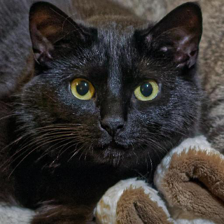

In [ ]:
# All images have a prefix of "flickr" or "pixabay", then the corresponding
# class name (cat, dog, wild) and a number, .. .jpg
with Image.open('/content/afhq/train/cat/flickr_cat_000032.jpg') as im:
  resized_image = im.resize((224,224))  # Resize the image
  display(resized_image)


In [ ]:
import random

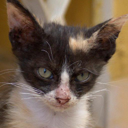

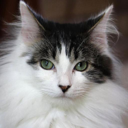

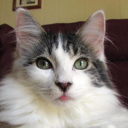

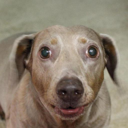

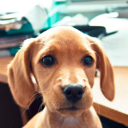

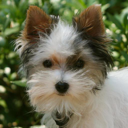

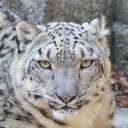

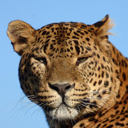

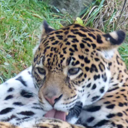

In [ ]:
from PIL import Image
from IPython.display import display

# Define the prefix, class names, and the range of numbers for the images
prefixes = ["flickr", "pixabay"]
class_names = ["cat", "dog", "wild"]
num_images_per_class = 3
image_size = (128, 128)  # size for displayed images

random.seed(42)
random_number = random.randint(1, 500)

# Iterate over the class names
for class_name in class_names:
    # Iterate over the prefixes
    # for prefix in prefixes:
        # Iterate over the range of numbers for the images
        # the images start with the number/index: 2 -> so the first image in train/cat is: 000002
        for number in range(random_number, num_images_per_class + random_number):
            image_path = f"/content/afhq/train/{class_name}/{prefixes[0]}_{class_name}_{number:06d}.jpg"
            try:
                with Image.open(image_path) as im:
                    resized_image = im.resize(image_size)  # Resize the image
                    display(resized_image)
            except FileNotFoundError:
                print(f"File not found: {image_path}")
                continue




Luckily the images in this dataset are all the same size (512x512).
Furthermore, as we can see from the randomly displayed images above, all of the images are already cropped to round about the center of the head of each individual animal. Making a further transformation of the images such as center-cropping not necessary.

## Common practice steps in preprocessing

It is a common practice to perform the following preprocessing steps:

1. Resize all the images to the same size. Most of the deep learning architectures expect the images to be of the same size. -> Our images are already all the same size.
2. Normalize the dataset with the mean and standard deviation of the dataset. -> We will do this with the mean and std of the ImageNet dataset.
3. Convert the image dataset to a PyTorch tensor.
4. Transformations for Data Augmentation.

Source:
* https://learning.oreilly.com/library/view/deep-learning-with/9781788624336/06de82d7-fb22-4b43-9149-1ea6c3fd7769.xhtml (Book: Deep Learning with PyTorch)

## Define our transforms

In this section we will perform image transformations to make our images suitable for training.

We will perform transformations (rotation, flipping etc.) that are used for data augmentation (enhancing the training dataset artificially through transformations).

We will resize the images, leading to faster training iterations.

Then we need to transform the pixel values of the image to tensors to make them usable for training.

After transforming to tensors, the pixel values need to be normalized.

The <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>recommended normalization parameters</a> for mean and std per channel.

Source: https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

In [ ]:
# TRAIN TRANSFORMS
# Compose() to perform a variety of transformations
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(p=0.5),  # reverse 50% of images
        transforms.Resize(224),             # resize to 224x224
        # resizing to a smaller dimension can speed up training iterations
        transforms.ToTensor(), # ToTensor()
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) # ImageNet normalisation params
    ])



In [ ]:
# TEST TRANSFORMS
# For the test set, we don't want to randomly rotate and randomly
# flip these images. Because we're really just using those transforms
# to test out the capability of the network to predict on a
# new real image of a dog or a cat or a wildlife animal.
# And the real images in the dataset, those aren't randomly rotated/flipped.

# But images in test set need to be in the same dimensions that the network was trained on.
# and be normalised, so that they are in the same value range that the network was trained on

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

## Preparing our train and test sets

Here we will load and split our data into training and test set and prepare the Batches using the DataLoader objects.

PyTorch offers the convenient ImageFolder class (a built-in torchvision dataset tool), which simplifies dataset preparation for such a structure. By providing the data directory as input, we can easily create a dataset that is ready for training our model.
For this to work, however, the files have to be in a certain directory structure. Main_Folder/train/class_name1; class_name2 etc.

[Source: https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48 ]

The DataLoader makes it easy to load and group data into the individual batches from a dataset.

Source:
* https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
# Load data using ImageFolder
path = '/content/afhq'

train_data = datasets.ImageFolder(os.path.join(path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(path, 'val'), transform=test_transform)




In [ ]:
# Our class names / the labels in our dataset
class_names = train_data.classes # our labels
print(class_names)

['cat', 'dog', 'wild']


In [ ]:
# Look at first entry in train dataset
image, label = train_data[0]
print(image.shape, label)

torch.Size([3, 224, 224]) 0


So our first image in the dataset has a shape (3,224,224).

Which means the image has 3 channels (RGB), height: 224, and width: 224.

The image has a label 0, which represents the "cat" class.

In [ ]:
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog', 'wild']
Training images available: 14630
Testing images available:  1500


Those aren't that many images for training/testing. But we need to keep in mind, that we have this list of transformations (Data Augmentation) we can perform on this data.

So essentially, as we're feeding in these randomly transformed batches during training, we're not only just showing the same 14630 available images every time; we're showing randomized rotations or flippings of them.

**Choosing the batch size:**

The batch size determines how many samples are processed together before updating the model's parameters.

The batch size affects some indicators such as overall training time, training time per epoch, and quality of the model. Usually, we chose the batch size as a power of two, in the range between 16 and 512. But generally, the size of 32 is a rule of thumb and a good initial choice. Source: https://www.baeldung.com/cs/learning-rate-batch-size#:~:text=The%20batch%20size%20affects%20some,and%20a%20good%20initial%20choice.

In our training dataset we have 14630 images. We will start by choosing a batch-size of 32. This means that the first 14624 images will be evenly divided into batches of 32 images each. So we will have 457 complete batches. The remaining 6 images (14630 - 14624) will form the last batch.

During training, the model will process the complete batches with the specified batch size, and in the last batch, it will process the remaining images, even if the batch size is smaller.

Source:
* https://stackoverflow.com/questions/60142351/optimal-batch-size-for-image-classification-using-deep-learning

By creating the train_loader object, we get an iterable that can be used to iterate over the training dataset in batches. Each iteration will provide a batch of samples with the specified batch size, and the order of the samples will be randomly shuffled if shuffle=True. This train_loader can be used in the training loop to feed the batches of data to the model for training.


By setting `shuffle=True` on the training dataset, we indicate that the data should be shuffled before each epoch (a complete pass through the dataset). When set to True, the DataLoader will randomly shuffle the samples within each epoch, ensuring that the model sees the data in different orderings during training, which can help prevent the model from being biased by the order of the data.

Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

By creating the test_loader object, we get an iterable that allows us to iterate over the test dataset in batches. Each iteration (like with the train_loader object) will provide a batch of samples with the specified batch size (32). The order of the samples will be preserved, as shuffle is set to False.


In [ ]:
# Preparing the batches and shuffle

torch.manual_seed(67) # seed for shuffling
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# do shuffle on training data
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
# don't shuffle on test data

## Display a single batch of images

We will display a batch of images, to make sure (to verify) that the training laoder selects "wild", "cat", and "dog" images at random.

 So we want it to be trained on cats, dogs, and wildlife simultaneaously so we can not learn all cats first and then all dogs and then all wildlife animals. Otherwise, it won't lead to a generalized model and would perform poorly.

So we need to make sure that it's feeding in both cats, dogs and wildlife animals kind of randomly at the same time, and that we are performing those random transformations, such as flipping horizontally or rotation.

Of course, we won't be able to tell if an image has been flipped horizontally as we don't know what all the available images in the training data look like.

Random rotations will be visible though, they will have little black edges around the images.

In [ ]:
# Grab the first batch of 32 images
for images,labels in train_loader:
    # we break immediately to only get the first batch
    break


In [ ]:
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
for imgs, labls in test_loader:
  break
imgs.shape

torch.Size([32, 3, 224, 224])

32 images, 3 color channels (R,G,B) where each channel is 224x224 (because of the transformations we did above in *resizing*)

Labels: 
1    0    0    2    0    1    1    2    
0    1    2    2    1    0    1    1    
1    0    2    1    1    2    0    0    
1    0    2    0    1    0    2    0    
Classes:
dog cat cat wild cat dog dog wild 
cat dog wild wild dog cat dog dog 
dog cat wild dog dog wild cat cat 
dog cat wild cat dog cat wild cat 


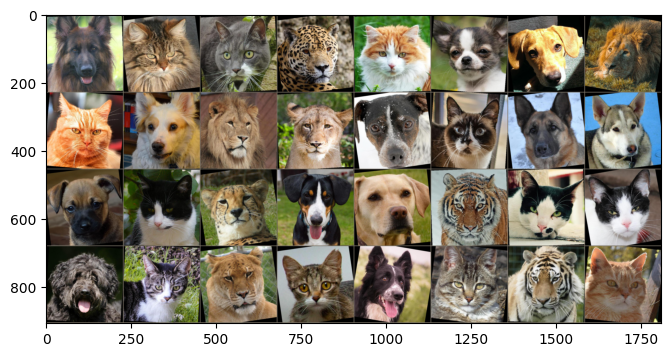

In [ ]:
# Print the labels and classes
print("Labels: ")
for i, label in enumerate(labels.numpy()):
    print(label, end='    ')
    if (i + 1) % 8 == 0: # display 8 labels per row
        print()
print("Classes:")
for i, label in enumerate(labels.numpy()):
    print(class_names[label], end=' ')
    if (i + 1) % 8 == 0:
        print()
# Print the images
im = make_grid(images, nrow=8) # make a grid of images (from pytorch torchvision)

# We normalized the images in the transformations, so
# we will need to inverse the normalisation to view the images

# Inverse normalize the images
# code taken from: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4)) # make the displayed images a little smaller
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));
# np.transpose(..) -> we have to transpose the axes in order to
# get the color channel to the correct dimension that matplotlib expects


We can see our batches are shuffled, as we get random images of dogs, cats, and wildlife animals.

And we can also see that some of the images are randomly rotated and some may be horizontally flipped.

But again, we can't see horizontal flippings as we haven't seen all the original images in the dataset.

## Preprocessing done ✅

## Define our Convoluional Neural Network model

CNNs are feed-forward networks. During the training process, the network will process the input through all the layers, compute the loss to understand how far the predicted label of the image is falling from the correct one, and propagate the gradients back into the network to update the weights of the layers. By iterating over a huge dataset of inputs, the network will “learn” to set its weights to achieve the best results. What we mean, when we talk about a network “learning”  -> is that it’s just minimising a cost/loss function.

How many layers?

Knowing the number of input and output layers and the number of their neurons is the easiest part. Every network has a single input layer and a single output layer. The number of neurons in the input layer equals the number of input variables in the data being processed. The number of neurons in the output layer equals the number of outputs associated with each input.

The number of hidden layers can be configured and is also a hyperparameter.

Source: https://stackoverflow.com/questions/60390707/how-to-choose-the-number-of-convolution-layers-and-filters-in-cnn

A CNN typically has three layers: a convolutional layer, a pooling layer, and a fully connected layer.

In [ ]:
# Here is a quick calculation, demonstrating how the output dimensions are calculated
# that are fed into the fully connected layers.

# In this model we have 2 convolutional layers and after each convolutional layer
# one max pooling layer (MaxPool with 2,2) -> so after each conv layer we cut
# the dimension in half
# right now: image_size = 224x224, kernel_size = 3, padding=0 and stride = 1
#(W−F+2P)/S+1
output_after_conv_layers = (224 - 3 + 2*0)/1 + 1
print(output_after_conv_layers)
output_after_conv_layers = output_after_conv_layers/2 # after max pooling
print(output_after_conv_layers)
output_after_conv_layers = (output_after_conv_layers - 3 + 2*0)/1 + 1
print(output_after_conv_layers)
output_after_conv_layers = output_after_conv_layers/2 # after max pooling
print(output_after_conv_layers)



222.0
111.0
109.0
54.5


In [ ]:
# Define the CNN

# inherit from nn.Module to have the ability
# to define and manage NN parameters and perform forward pass computations.
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,6,3,1) # 1st convolutional layer
    self.conv2 = nn.Conv2d(6,16,3,1) # 2nc conv layer

    # Calculation for number of in_features for FC layer
    # in_features = (output_height * output_width * out_channels)
    # output_height and -width = 54 (calculation above)
    # out_channels = 16 (= Nr. of output channels from the last convolutional layer before the fully connected layer.)
    self.fc1 = nn.Linear(in_features=54*54*16, out_features=1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128,3) # 3 final out_features, bc. 3 classes (wild, dog, cat)


  def forward(self,X): # Forward

        # 1st set: conv + pooling layer
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)

        # 2nd set: conv + pooling layer
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) # 2x2 with a stride of 2 -> halve the dimenions

        # Linear Layers
        # flatten out the data first
        X = X.view(-1, 54*54*16)
        # -1, because "-1" assumes whatever the first batch size is.

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        # our final activation function is log_softmax
        # because we're performing a Multiclass classificaition, since we have 3 classes
        # cat, dog, wild
        return F.log_softmax(X, dim=1)


In [ ]:
torch.manual_seed(42)
model = ConvolutionalNetwork().to(device)
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

##  Define a Loss function and optimizer


In [ ]:
criterion = nn.CrossEntropyLoss() # bc. it's multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

A loss function computes a value that estimates how far away the output is from the target. The main objective is to reduce the loss function's value by changing the weight vector values through backpropagation in neural networks.

In this step-by.step guide, we will cross-entropy loss (because we're dong multiclass classification) and the Adam optimizer.

Learning rate (lr) sets the control of how much you are adjusting the weights of our network with respect the loss gradient. We will set it as 0.001. The lower it is, the slower the training will be.


Source:
* https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model

## Train the model on the training data.

Common practice to validate the model during the training loop in image classification
which helps monitor the performance of the model on unseen data and allows for early stopping or fine-tuning of hyperparameters.



In [ ]:
image_shape = image.shape[1]
image_shape

224

In [ ]:
import time
start_time = time.time()
batch_size = 32
epochs = 10
train_losses = []
train_correct = []

test_losses = []
test_correct = []

for i in tqdm(range(epochs)):
    print()
    # Training
    model.train()
    trn_corr = 0

    # Run the training batches
    # b is batch
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Source: https://www.kaggle.com/code/kdnishanth/pytorch-cnn-tutorial-in-gpu
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Apply the model (# Forward pass)
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters (Backward pass)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results every 100 batches (with batch_size=32 -> we have 458 batches in our training set)
        if b%100 == 0:
            print(f"\nEPOCH: {i}, BATCH: {b}, LOSS: {loss.item()}, ACC: {(trn_corr.item()*100)/(b * batch_size):7.3f}%")

    # source: https://stackoverflow.com/questions/53900910/typeerror-can-t-convert-cuda-tensor-to-numpy-use-tensor-cpu-to-copy-the-tens
    train_losses.append(loss.detach().cpu().numpy()) # for plotting it out later
    train_correct.append(trn_corr)



    # Validation
    # Run the testing batches
    # Since we're not training, we don't need to calculate the gradients for our outputs
    # so we don't accidentally update our weights and biases with the test data
    model.eval()
    tst_corr = 0

    # We will use the test set for validation as well.

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            X_test = X_test.to(device)
            y_test = y_test.to(device)

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().cpu().numpy())
    test_correct.append(tst_corr)

    # Accuracy after each epoch
    accuracy = trn_corr.item() / len(train_loader.dataset)
    print(f"\nAccuracy after epoch {i+1}: {accuracy*100:.2f}%")


print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

# Save the trained model
PATH = f'./model_with_{epochs}_epochs_dimension_{image_shape}.pt'
torch.save(model.state_dict(), PATH)

  0%|          | 0/10 [00:00<?, ?it/s]



EPOCH: 0, BATCH: 100, LOSS: 0.6296083331108093, ACC:  64.125%

EPOCH: 0, BATCH: 200, LOSS: 0.29304689168930054, ACC:  74.422%

EPOCH: 0, BATCH: 300, LOSS: 0.21375232934951782, ACC:  78.802%

EPOCH: 0, BATCH: 400, LOSS: 0.4270184636116028, ACC:  81.742%


 10%|█         | 1/10 [02:30<22:35, 150.57s/it]


Accuracy after epoch 1: 82.81%


EPOCH: 1, BATCH: 100, LOSS: 0.2666039764881134, ACC:  91.406%

EPOCH: 1, BATCH: 200, LOSS: 0.057268884032964706, ACC:  91.969%

EPOCH: 1, BATCH: 300, LOSS: 0.05850562825798988, ACC:  92.406%

EPOCH: 1, BATCH: 400, LOSS: 0.17407289147377014, ACC:  92.328%


 20%|██        | 2/10 [04:58<19:51, 148.92s/it]


Accuracy after epoch 2: 92.73%


EPOCH: 2, BATCH: 100, LOSS: 0.042257536202669144, ACC:  94.906%

EPOCH: 2, BATCH: 200, LOSS: 0.22536543011665344, ACC:  94.938%

EPOCH: 2, BATCH: 300, LOSS: 0.2492995262145996, ACC:  94.875%

EPOCH: 2, BATCH: 400, LOSS: 0.14274609088897705, ACC:  94.906%


 30%|███       | 3/10 [07:32<17:39, 151.36s/it]


Accuracy after epoch 3: 94.92%


EPOCH: 3, BATCH: 100, LOSS: 0.025688905268907547, ACC:  95.219%

EPOCH: 3, BATCH: 200, LOSS: 0.021941514685750008, ACC:  95.578%

EPOCH: 3, BATCH: 300, LOSS: 0.06514671444892883, ACC:  95.458%

EPOCH: 3, BATCH: 400, LOSS: 0.2800586223602295, ACC:  95.547%


 40%|████      | 4/10 [10:02<15:05, 150.88s/it]


Accuracy after epoch 4: 95.56%


EPOCH: 4, BATCH: 100, LOSS: 0.03384639322757721, ACC:  96.344%

EPOCH: 4, BATCH: 200, LOSS: 0.09885721653699875, ACC:  96.312%

EPOCH: 4, BATCH: 300, LOSS: 0.1396828591823578, ACC:  96.490%

EPOCH: 4, BATCH: 400, LOSS: 0.16213960945606232, ACC:  96.430%


 50%|█████     | 5/10 [12:29<12:27, 149.49s/it]


Accuracy after epoch 5: 96.44%


EPOCH: 5, BATCH: 100, LOSS: 0.2635185718536377, ACC:  97.062%

EPOCH: 5, BATCH: 200, LOSS: 0.07177301496267319, ACC:  97.016%

EPOCH: 5, BATCH: 300, LOSS: 0.013062567450106144, ACC:  97.312%

EPOCH: 5, BATCH: 400, LOSS: 0.22540153563022614, ACC:  97.211%


 60%|██████    | 6/10 [14:57<09:55, 148.91s/it]


Accuracy after epoch 6: 97.22%


EPOCH: 6, BATCH: 100, LOSS: 0.013678123243153095, ACC:  97.406%

EPOCH: 6, BATCH: 200, LOSS: 0.02459581568837166, ACC:  97.500%

EPOCH: 6, BATCH: 300, LOSS: 0.03219297155737877, ACC:  97.604%

EPOCH: 6, BATCH: 400, LOSS: 0.0235302597284317, ACC:  97.633%


 70%|███████   | 7/10 [17:20<07:20, 146.93s/it]


Accuracy after epoch 7: 97.59%


EPOCH: 7, BATCH: 100, LOSS: 0.004976243246346712, ACC:  97.500%

EPOCH: 7, BATCH: 200, LOSS: 0.006129606161266565, ACC:  97.562%

EPOCH: 7, BATCH: 300, LOSS: 0.004973941948264837, ACC:  97.531%

EPOCH: 7, BATCH: 400, LOSS: 0.022898929193615913, ACC:  97.695%


 80%|████████  | 8/10 [19:40<04:49, 144.84s/it]


Accuracy after epoch 8: 97.75%


EPOCH: 8, BATCH: 100, LOSS: 0.004649809096008539, ACC:  98.031%

EPOCH: 8, BATCH: 200, LOSS: 0.0010893759317696095, ACC:  98.141%

EPOCH: 8, BATCH: 300, LOSS: 0.0802694782614708, ACC:  98.073%

EPOCH: 8, BATCH: 400, LOSS: 0.009367866441607475, ACC:  97.938%


 90%|█████████ | 9/10 [22:05<02:24, 144.76s/it]


Accuracy after epoch 9: 98.00%


EPOCH: 9, BATCH: 100, LOSS: 0.027366099879145622, ACC:  98.875%

EPOCH: 9, BATCH: 200, LOSS: 0.018709970638155937, ACC:  98.484%

EPOCH: 9, BATCH: 300, LOSS: 0.05641719698905945, ACC:  98.500%

EPOCH: 9, BATCH: 400, LOSS: 0.07828684896230698, ACC:  98.359%


100%|██████████| 10/10 [24:24<00:00, 146.44s/it]


Accuracy after epoch 10: 98.28%

Duration: 1464 seconds


## Plot the loss and accuracy comparisons / Evaluate the performance of the model

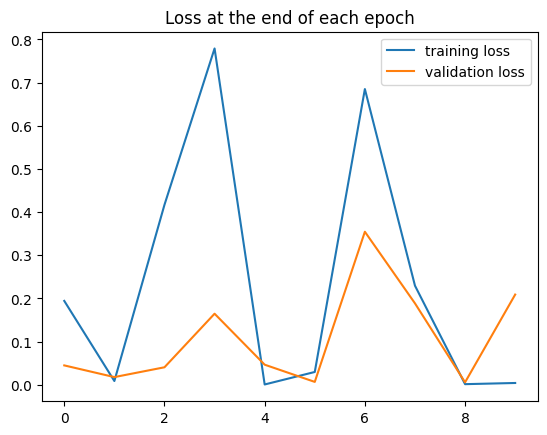

In [ ]:
# Plot the loss comparisons
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

Now we trained the same network with 10 epochs and kept all other hyperparameters the same.

This is what we wanna see: Validation/test loss right in line with our training loss.

In [ ]:
train_correct

[tensor(12115, device='cuda:0'),
 tensor(13566, device='cuda:0'),
 tensor(13887, device='cuda:0'),
 tensor(13980, device='cuda:0'),
 tensor(14109, device='cuda:0'),
 tensor(14224, device='cuda:0'),
 tensor(14278, device='cuda:0'),
 tensor(14301, device='cuda:0'),
 tensor(14338, device='cuda:0'),
 tensor(14378, device='cuda:0')]

In [ ]:
test_correct

[tensor(1362, device='cuda:0'),
 tensor(1386, device='cuda:0'),
 tensor(1411, device='cuda:0'),
 tensor(1419, device='cuda:0'),
 tensor(1423, device='cuda:0'),
 tensor(1388, device='cuda:0'),
 tensor(1442, device='cuda:0'),
 tensor(1443, device='cuda:0'),
 tensor(1445, device='cuda:0'),
 tensor(1444, device='cuda:0')]

In [ ]:
print(len(train_data))
print(len(test_data))

14630
1500


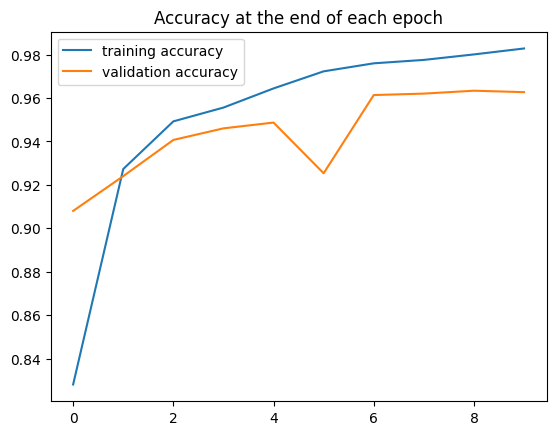

In [ ]:
# Plot the accuracy comparisons
plt.plot([t.cpu()/len(train_data) for t in train_correct], label='training accuracy')
plt.plot([t.cpu()/(len(test_data)) for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

A clear trend can be seen. The validation accuracy and training accuracy are both heading in the same direction. Training for more epochs would likely result in an ever clearer trend.

## Test the network on the entire test data


In [ ]:
# Extract the test data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [ ]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 1444/1500 =  96.267%


In [ ]:
# Test accuracy of 95.467% with:
# 10 epochs
# batch_size = 32
# kernel = 3x3, stride = 1, padding = 0